In [1]:
PARKINGS = [
    "Gto-Alhondiga",
    "Gto-Alonso",
    "Gto-Hinojo",
    "Gto-SanPedro",
]

In [2]:
import pandas as pd

csv_path = "https://raw.githubusercontent.com/L4rralde/Parking_Lots/refs/heads/main/data/data.csv"

data = pd.read_csv(csv_path)
data = data.drop(columns=["Unnamed: 0", "Leon-Mariachi", "Irapuato-Hidalgo"])
data["Fecha_Hora"] = pd.to_datetime(data["Fecha_Hora"])
data.set_index(["Fecha_Hora"], inplace=True)
means = data.mean()
stds = data.std()

data = (data - means)/stds

In [3]:
data["Dia_Semana"] = data.index.weekday
data["Hora"] = data.index.hour
data["Minuto"] = data.index.minute
data["Horas_Semana"] = data["Dia_Semana"]*24 + data["Hora"]
data["Minutos_Semana"] = data["Dia_Semana"]*1440 + data["Hora"]*60 + data["Minuto"]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import KFold


train, test = train_test_split(data, test_size=0.2, shuffle=False)

kf = KFold(n_splits=10, shuffle=False)
folds = [
    (train.iloc[train_idx], train.iloc[val_idx])
    for train_idx, val_idx in kf.split(train)
]


In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
regressor = LinearRegression(n_jobs=4)

In [7]:
def mse(model, subset, predictors, response):
    val_y = subset[response].values.ravel()
    val_yhat = model.predict(subset[predictors])
    return ((val_y - val_yhat)**2).mean()

def cross_validation(model, predictors, response):
    train_error = 0
    val_error = 0
    for i, (train_set, val_set) in enumerate(folds):
        model.fit(train_set[predictors], train_set[response].values.ravel())
        train_error += mse(model, train_set, predictors, response)
        val_error += mse(model, val_set, predictors, response)
    return (train_error/len(folds), val_error/len(folds))

In [8]:
cross_validation(
    model = regressor,
    predictors = ["Hora"],
    response = ["Gto-Alonso"]
)

(0.7818573511416796, 0.8437531995544981)

In [9]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [24]:
from tqdm import tqdm
for predictors in tqdm(list(powerset(data.columns.drop("Gto-Alonso")))):
    if not 0 < len(predictors) < 5:
        continue
    matching = [s for s in predictors if "Gto" in s]
    if len(matching) > 0:
        continue
    predictors = list(predictors)
    train_error, val_error = cross_validation(
        model = regressor,
        predictors = predictors,
        response = ["Gto-Alonso"]
    )
    if val_error > 0.75:
        continue
    print(predictors)
    print(train_error, val_error)
    print()

 24%|██████████████████████████▏                                                                                   | 122/512 [00:00<00:00, 470.55it/s]

['Dia_Semana', 'Hora']
0.6875142353510597 0.7399682378032684

['Dia_Semana', 'Horas_Semana']
0.6875142353510597 0.7399682378032679

['Dia_Semana', 'Minutos_Semana']
0.687829781254217 0.7403672625286262

['Hora', 'Horas_Semana']
0.6875142353510597 0.7399682378032685

['Hora', 'Minutos_Semana']
0.6875103646526846 0.7399703177616046

['Dia_Semana', 'Hora', 'Minuto']
0.6874941796242717 0.7402935261355893

['Dia_Semana', 'Hora', 'Horas_Semana']
0.6875142353510597 0.7399682378032683

['Dia_Semana', 'Hora', 'Minutos_Semana']
0.6874941796242717 0.7402935261354334



 33%|████████████████████████████████████▌                                                                         | 170/512 [00:00<00:00, 408.24it/s]

['Dia_Semana', 'Minuto', 'Horas_Semana']
0.6874941796242717 0.740293526135589

['Dia_Semana', 'Minuto', 'Minutos_Semana']
0.6874941796242717 0.7402935261355887

['Dia_Semana', 'Horas_Semana', 'Minutos_Semana']
0.6874941796242717 0.7402935261356047

['Hora', 'Minuto', 'Horas_Semana']
0.6874941796242717 0.7402935261355893

['Hora', 'Minuto', 'Minutos_Semana']
0.6874941796242717 0.7402935261355893

['Hora', 'Horas_Semana', 'Minutos_Semana']
0.6874941796242717 0.7402935261355897

['Dia_Semana', 'Hora', 'Minuto', 'Horas_Semana']
0.6874941796242717 0.7402935261355891

['Dia_Semana', 'Hora', 'Minuto', 'Minutos_Semana']
0.6874941796242717 0.7402935261355867

['Dia_Semana', 'Hora', 'Horas_Semana', 'Minutos_Semana']
0.6874941796242717 0.7402935261354198

['Dia_Semana', 'Minuto', 'Horas_Semana', 'Minutos_Semana']
0.6874941796242717 0.7402935261355889



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 925.43it/s]

['Hora', 'Minuto', 'Horas_Semana', 'Minutos_Semana']
0.6874941796242717 0.7402935261355895



In [10]:
from tqdm import tqdm
for predictors in tqdm(list(powerset(data.columns.drop("Gto-Alonso")))):
    if not 0 < len(predictors) < 5:
        continue
    matching = [s for s in predictors if "Gto" in s]
    if len(matching) > 2:
        continue
    predictors = list(predictors)
    train_error, val_error = cross_validation(
        model = regressor,
        predictors = predictors,
        response = ["Gto-Alonso"]
    )
    if val_error > 0.44:
        continue
    print(predictors)
    print(train_error, val_error)
    print()

 30%|████████████████████████████████▉                                                                              | 152/512 [00:02<00:04, 72.94it/s]

['Gto-Alhondiga', 'Gto-Hinojo', 'Dia_Semana', 'Hora']
0.3461716483216532 0.4387636484925129

['Gto-Alhondiga', 'Gto-Hinojo', 'Dia_Semana', 'Horas_Semana']
0.3461716483216532 0.4387636484925134

['Gto-Alhondiga', 'Gto-Hinojo', 'Dia_Semana', 'Minutos_Semana']
0.3459671398644152 0.4384051488452988

['Gto-Alhondiga', 'Gto-Hinojo', 'Hora', 'Horas_Semana']
0.3461716483216532 0.4387636484925127

['Gto-Alhondiga', 'Gto-Hinojo', 'Hora', 'Minutos_Semana']
0.34612773928188956 0.4387097078828056



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:04<00:00, 123.54it/s]


In [13]:
from tqdm import tqdm
for predictors in tqdm(list(powerset(data.columns.drop("Gto-Alonso")))):
    if not 0 < len(predictors) < 6:
        continue
    matching = [s for s in predictors if "Gto" in s]
    if len(matching) > 3:
        continue
    predictors = list(predictors)
    train_error, val_error = cross_validation(
        model = regressor,
        predictors = predictors,
        response = ["Gto-Alonso"]
    )
    if val_error > 0.43:
        continue
    print(predictors)
    print(train_error, val_error)
    print()

 53%|██████████████████████████████████████████████████████████▎                                                    | 269/512 [00:04<00:04, 56.34it/s]

['Gto-Alhondiga', 'Gto-Hinojo', 'Gto-Pozuelos', 'Dia_Semana', 'Hora']
0.3261172093299516 0.42390548292100777

['Gto-Alhondiga', 'Gto-Hinojo', 'Gto-Pozuelos', 'Dia_Semana', 'Horas_Semana']
0.3261172093299516 0.42390548292100744

['Gto-Alhondiga', 'Gto-Hinojo', 'Gto-Pozuelos', 'Dia_Semana', 'Minutos_Semana']
0.3259241854453828 0.423570966416528

['Gto-Alhondiga', 'Gto-Hinojo', 'Gto-Pozuelos', 'Hora', 'Horas_Semana']
0.3261172093299516 0.4239054829210077

['Gto-Alhondiga', 'Gto-Hinojo', 'Gto-Pozuelos', 'Hora', 'Minutos_Semana']
0.3260704064039203 0.42384770229949426



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 69.85it/s]


In [16]:
from tqdm import tqdm
for predictors in tqdm(list(powerset(data.columns.drop("Gto-Alonso")))):
    if not predictors:
        continue
    predictors = list(predictors)
    train_error, val_error = cross_validation(
        model = regressor,
        predictors = predictors,
        response = ["Gto-Alonso"]
    )
    if val_error > 0.423:
        continue
    print(predictors)
    print(train_error, val_error)
    print()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:10<00:00, 50.39it/s]


In [33]:
predictors = ['Dia_Semana', 'Minutos_Semana']
response = ['Gto-Alonso']
regressor = LinearRegression(n_jobs=4)

regressor.fit(train[predictors], train[response].values.ravel())
regressor.score(test[predictors], test[response].values.ravel())

0.24689311249157475

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
/var/folders/y8/gfw8crg95jdf0ymxjbqm7hlm0000gn/T/ipykernel_17021/3139324158.py:9: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(y.index, yhat*stds[response].values.ravel() + means[response].values.ravel(), label='$\hat y$', alpha=0.8)


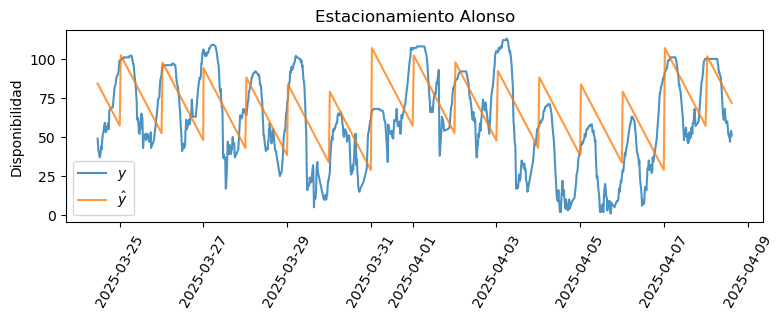

['Dia_Semana', 'Minutos_Semana']
0.24689311249157475
0.6578035072122359


In [37]:
import matplotlib.pyplot as plt

y = test[response]
yhat = regressor.predict(test[predictors])
mse = ((y.values.ravel() - yhat)**2).mean()

plt.figure(figsize=(9, 2.5))
plt.plot(y.index, (y*stds + means)[response].values.ravel(), label='$y$', alpha=0.8)
plt.plot(y.index, yhat*stds[response].values.ravel() + means[response].values.ravel(), label='$\hat y$', alpha=0.8)
plt.xticks(rotation=60)

plt.title("Estacionamiento Alonso")
plt.ylabel("Disponibilidad")
plt.legend()
plt.savefig("media/linear_regression.jpeg")
plt.show()

print(predictors)
print(regressor.score(test[predictors], test[response].values.ravel()))
print(mse)